In [162]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [163]:
from fastai.tabular.all import *

In [164]:
path = "/content/combined_five_seasons_data.csv"

Then we can have a look at how the data is structured:

In [165]:
df = pd.read_csv(path)
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,ScoreDiff,Results,HomeWinStreak,AwayWinStreak,TGSH,TGSA
0,Burnley,Swansea,0,1,-1,Loss,0,0,0,0
1,Crystal Palace,West Brom,0,1,-1,Loss,0,0,0,0
2,Everton,Tottenham,1,1,0,Draw,0,0,0,0
3,Hull,Leicester,2,1,1,Win,1,0,0,0
4,Man City,Sunderland,2,1,1,Win,2,0,0,0


Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical (like workclass or education) and we will convert them to a unique index that we will feed to embedding layers. We can specify our categorical and continuous column names, as well as the name of the dependent variable in `TabularDataLoaders` factory methods:

In [166]:
dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
    cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA'],
    #cont_names = ['ScoreDiff'],
    procs = [Categorify, FillMissing, Normalize])

The last part is the list of pre-processors we apply to our data:

- `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
- `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
- `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)



To further expose what's going on below the surface, let's rewrite this utilizing `fastai`'s `TabularPandas` class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [167]:
splits = EndSplitter(valid_pct=0.1, valid_last=True)(range_of(df))

In [168]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA'],
                   #cont_names = ['ScoreDiff'],
                   y_names='Results',
                   splits=splits)

Once we build our `TabularPandas` object, our data is completely preprocessed as seen below:

In [169]:
to.xs.iloc[:2]

,HomeTeam,AwayTeam,TGSH,TGSA
0,5,25,1,1
1,8,28,1,1


Now we can build our `DataLoaders` again:

In [170]:
dls = to.dataloaders(bs=64)

> Later we will explore why using `TabularPandas` to preprocess will be valuable.

The `show_batch` method works like for every other application:

In [171]:
dls.show_batch()

,HomeTeam,AwayTeam,TGSH,TGSA,Results
0,Southampton,Everton,0,0,Win
1,Watford,Sunderland,0,0,Win
2,Man City,Arsenal,0,0,Win
3,Man City,Brighton,0,0,Win
4,West Ham,Southampton,0,0,Loss
5,Middlesbrough,Everton,0,0,Draw
6,Watford,Bournemouth,0,0,Draw
7,Swansea,Crystal Palace,0,0,Win
8,Burnley,Arsenal,0,0,Draw
9,West Ham,Leicester,0,0,Draw


We can define a model using the `tabular_learner` method. When we define our model, `fastai` will try to infer the loss function based on our `y_names` earlier. 

**Note**: Sometimes with tabular data, your `y`'s may be encoded (such as 0 and 1). In such a case you should explicitly pass `y_block = CategoryBlock` in your constructor so `fastai` won't presume you are doing regression.

In [172]:
learn = tabular_learner(dls, metrics=accuracy)

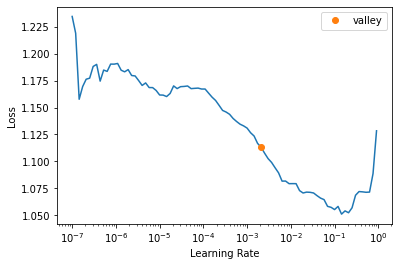

In [173]:
lr = learn.lr_find()

And we can train that model with the `fit_one_cycle` method (the `fine_tune` method won't be useful here since we don't have a pretrained model).

In [174]:
learn.fit_one_cycle(10, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,accuracy,time
0,1.100281,1.073241,0.410526,00:00
1,0.982575,1.059490,0.436842,00:00
2,0.939553,1.002694,0.521053,00:00
3,0.892565,1.113894,0.452632,00:00
4,0.858915,1.095063,0.426316,00:00
5,0.822402,1.083735,0.489474,00:00
6,0.785104,1.168845,0.478947,00:00
7,0.743435,1.175244,0.442105,00:00
8,0.708093,1.178763,0.436842,00:00
9,0.681404,1.185504,0.426316,00:00


We can then have a look at some predictions:

In [175]:
learn.show_results(max_n=10)

,HomeTeam,AwayTeam,TGSH,TGSA,Results,Results_pred
0,26,28,1,1,2,0
1,7,19,1,1,2,2
2,16,17,1,1,1,2
3,14,26,1,1,1,1
4,15,9,1,1,1,0
5,19,21,2,1,2,2
6,13,15,1,1,0,1
7,29,14,1,1,2,1
8,22,4,1,1,1,0
9,10,5,1,1,1,2


Or use the predict method on a row:

In [176]:
row, clas, probs = learn.predict(df.iloc[9])

In [177]:
row.show()

,HomeTeam,AwayTeam,TGSH,TGSA,Results
0,Chelsea,West Ham,0,0,Win


In [178]:
clas, probs

(tensor(2), tensor([0.2458, 0.2246, 0.5295]))